<a href="https://colab.research.google.com/github/divyansh1654/MaxHealthcare_Assessment-/blob/main/MaxHealthcare_HomeTest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q numpy matplotlib scikit-learn torch torchvision tqdm


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from tqdm import tqdm

In [4]:
x_train = np.load("/content/x_train.npy")
y_train = np.load("/content/y_train.npy")
x_val   = np.load("/content/x_val.npy")
y_val   = np.load("/content/y_val.npy")


print("Train images:", x_train.shape)
print("Train labels:", y_train.shape)
print("Val images:", x_val.shape)
print("Val labels:", y_val.shape)



Train images: (7007, 28, 28, 3)
Train labels: (7007, 1)
Val images: (1003, 28, 28, 3)
Val labels: (1003, 1)


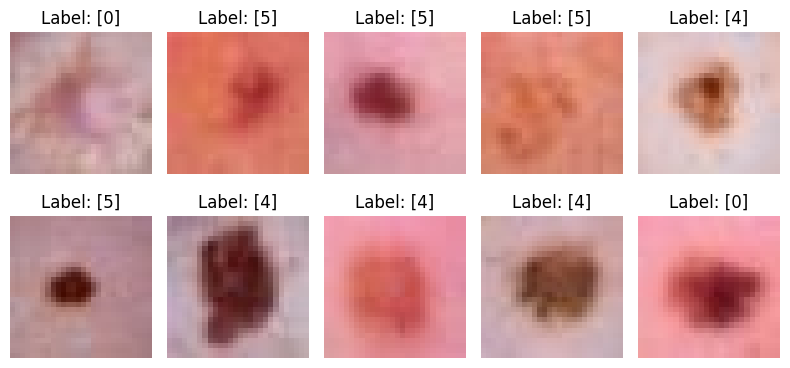

In [5]:
plt.figure(figsize=(8, 4))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(x_train[i], cmap='gray')
    plt.title(f"Label: {y_train[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()


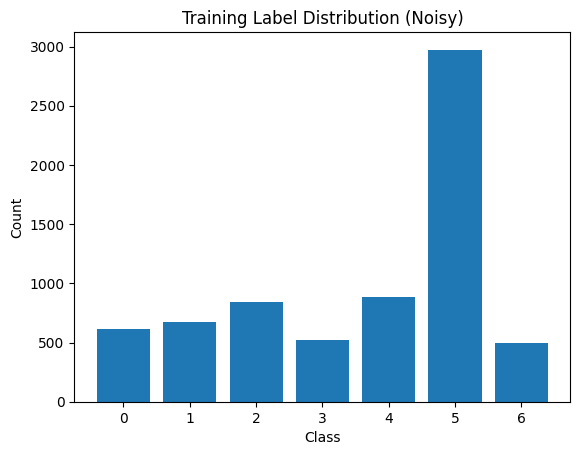

In [6]:
unique, counts = np.unique(y_train, return_counts=True)
plt.bar(unique, counts)
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Training Label Distribution (Noisy)")
plt.show()


In [7]:
class SkinDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx].astype(np.float32) / 255.0

        if img.ndim == 3:
            img = img.mean(axis=2)

        img = torch.tensor(img).unsqueeze(0)
        label = int(self.labels[idx])

        return img, label


In [8]:
batch_size = 64

train_dataset = SkinDataset(x_train, y_train)
val_dataset = SkinDataset(x_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [9]:
class CNN(nn.Module):
    def __init__(self, num_classes=7):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)


In [10]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)

best_val_acc = 0
train_losses = []
val_accuracies = []

for epoch in range(15):
    model.train()
    running_loss = 0

    for imgs, labels in tqdm(train_loader):
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))

    model.eval()
    preds, gt = [], []

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs = imgs.to(device)
            outputs = model(imgs)
            preds.extend(outputs.argmax(1).cpu().numpy())
            gt.extend(labels.numpy())

    val_acc = accuracy_score(gt, preds)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}: Loss={train_losses[-1]:.4f}, Val Acc={val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")


  0%|          | 0/110 [00:00<?, ?it/s]/tmp/ipython-input-3550638848.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(self.labels[idx])
100%|██████████| 110/110 [00:10<00:00, 10.79it/s]


Epoch 1: Loss=1.7808, Val Acc=0.6690


  0%|          | 0/110 [00:00<?, ?it/s]/tmp/ipython-input-3550638848.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(self.labels[idx])
100%|██████████| 110/110 [00:09<00:00, 11.64it/s]


Epoch 2: Loss=1.7601, Val Acc=0.6690


  0%|          | 0/110 [00:00<?, ?it/s]/tmp/ipython-input-3550638848.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(self.labels[idx])
100%|██████████| 110/110 [00:10<00:00, 10.92it/s]


Epoch 3: Loss=1.7518, Val Acc=0.6690


  0%|          | 0/110 [00:00<?, ?it/s]/tmp/ipython-input-3550638848.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(self.labels[idx])
100%|██████████| 110/110 [00:10<00:00, 10.83it/s]


Epoch 4: Loss=1.7434, Val Acc=0.6690


  0%|          | 0/110 [00:00<?, ?it/s]/tmp/ipython-input-3550638848.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(self.labels[idx])
100%|██████████| 110/110 [00:10<00:00, 10.65it/s]


Epoch 5: Loss=1.7392, Val Acc=0.6690


  0%|          | 0/110 [00:00<?, ?it/s]/tmp/ipython-input-3550638848.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(self.labels[idx])
100%|██████████| 110/110 [00:09<00:00, 11.15it/s]


Epoch 6: Loss=1.7342, Val Acc=0.6690


  0%|          | 0/110 [00:00<?, ?it/s]/tmp/ipython-input-3550638848.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(self.labels[idx])
100%|██████████| 110/110 [00:09<00:00, 11.62it/s]


Epoch 7: Loss=1.7305, Val Acc=0.6690


  0%|          | 0/110 [00:00<?, ?it/s]/tmp/ipython-input-3550638848.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(self.labels[idx])
100%|██████████| 110/110 [00:18<00:00,  5.95it/s]


Epoch 8: Loss=1.7305, Val Acc=0.6690


  0%|          | 0/110 [00:00<?, ?it/s]/tmp/ipython-input-3550638848.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(self.labels[idx])
100%|██████████| 110/110 [00:10<00:00, 10.64it/s]


Epoch 9: Loss=1.7256, Val Acc=0.6700


  0%|          | 0/110 [00:00<?, ?it/s]/tmp/ipython-input-3550638848.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(self.labels[idx])
100%|██████████| 110/110 [00:09<00:00, 11.29it/s]


Epoch 10: Loss=1.7256, Val Acc=0.6700


  0%|          | 0/110 [00:00<?, ?it/s]/tmp/ipython-input-3550638848.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(self.labels[idx])
100%|██████████| 110/110 [00:09<00:00, 11.39it/s]


Epoch 11: Loss=1.7195, Val Acc=0.6700


  0%|          | 0/110 [00:00<?, ?it/s]/tmp/ipython-input-3550638848.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(self.labels[idx])
100%|██████████| 110/110 [00:10<00:00, 10.66it/s]


Epoch 12: Loss=1.7188, Val Acc=0.6730


  0%|          | 0/110 [00:00<?, ?it/s]/tmp/ipython-input-3550638848.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(self.labels[idx])
100%|██████████| 110/110 [00:10<00:00, 10.69it/s]


Epoch 13: Loss=1.7132, Val Acc=0.6710


  0%|          | 0/110 [00:00<?, ?it/s]/tmp/ipython-input-3550638848.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(self.labels[idx])
100%|██████████| 110/110 [00:10<00:00, 10.59it/s]


Epoch 14: Loss=1.7110, Val Acc=0.6780


  0%|          | 0/110 [00:00<?, ?it/s]/tmp/ipython-input-3550638848.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(self.labels[idx])
100%|██████████| 110/110 [00:10<00:00, 10.64it/s]


Epoch 15: Loss=1.7096, Val Acc=0.6740


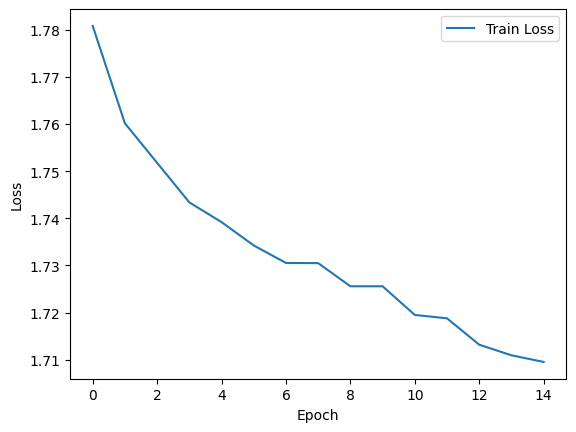

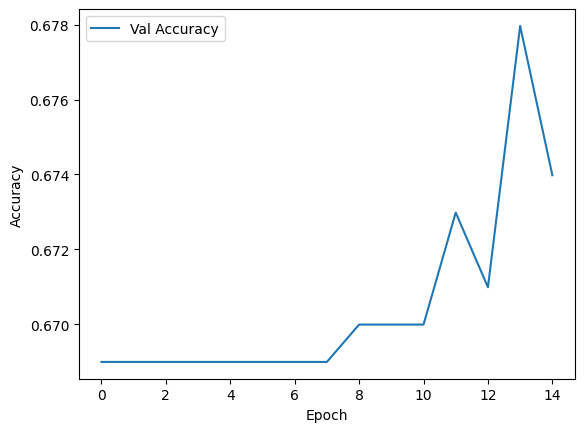

In [12]:
plt.plot(train_losses, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(val_accuracies, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [13]:
def run_inference_npy(
    x_val_path="/content/x_val.npy",
    y_val_path="/content/y_val.npy",
    model_path="best_model.pth"
):
    x_test = np.load(x_val_path)
    y_test = np.load(y_val_path)

    test_dataset = SkinDataset(x_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    model = CNN().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    preds, gt = [], []

    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs = imgs.to(device)
            outputs = model(imgs)
            preds.extend(outputs.argmax(1).cpu().numpy())
            gt.extend(labels.numpy())

    acc = accuracy_score(gt, preds)
    print("Accuracy:", acc)
    return acc



In [14]:
def run_inference(
    x_val_path="/content/x_val.npy",
    y_val_path="/content/y_val.npy",
    model_path="/content/best_model.pth"
):
    import numpy as np
    import torch

    x_test = np.load(x_val_path)
    y_test = np.load(y_val_path)

    test_dataset = SkinDataset(x_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    model = CNN().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    preds, gt = [], []

    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs = imgs.to(device)
            outputs = model(imgs)
            preds.extend(outputs.argmax(1).cpu().numpy())
            gt.extend(labels.numpy())

    acc = accuracy_score(gt, preds)
    print(f"Accuracy: {acc:.4f}")
    return acc


In [15]:
run_inference()

/tmp/ipython-input-3550638848.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(self.labels[idx])


Accuracy: 0.6780


0.6779661016949152